In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

os.chdir("/home/joaopedro/gdrive/Projects/active/Wild_Duck_Pipeline/wd/test_stars")

# Get centroid

Simple centroid
    
$$ x_c = \frac{\Sigma I_i x_i}{\Sigma I_i} $$

18.39478566492834 15.995969316471864


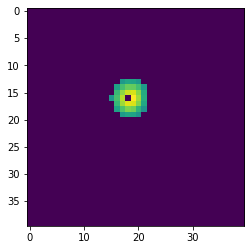

In [10]:
from astropy.stats import mad_std

star = np.loadtxt("test_star.csv", delimiter=",")
star2 = np.copy(star)
sky = mad_std(star)

# Rough sky subtraction
star -= sky

#  Defining half maxima
half_maxima = star.max()/2

#  Mask to get all values above half maxima
hm_mask = star >= half_maxima
star[~hm_mask] = 0

sum_ = star.sum()
indices = np.ogrid[[slice(0, i) for i in star.shape]]
sx = np.sum(indices[1] * star)
sy = np.sum(indices[0] * star)

xc = sx/sum_
yc = sy/sum_

print(xc, yc)
star[16, 18] = 0
plt.imshow(star)

In [11]:
np.arange(40)
np.sum(star, axis = 0).shape


(40,)

In [12]:
# Comparizon with photutils

data = np.copy(star)
total = np.sum(data)
indices = np.ogrid[[slice(0, i) for i in data.shape]]
# note the output array is reversed to give (x, y) order
ind = np.array([np.sum(indices[axis] * data) / total
                     for axis in range(data.ndim)])[::-1]

print(ind)

[18.40952405 15.99581884]


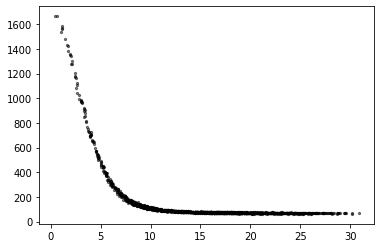

In [13]:
dist = np.sqrt((yc - indices[0])**2 + (xc - indices[1])**2)
plt.scatter(dist.ravel(), star2.ravel(), alpha = .5, c = "k", s = 5, marker = "o")

# Calculate MFWHM

Get initial kicks for a moffat function model, then optmize.

In [14]:
from astropy.modeling.models import Moffat1D
from astropy.modeling.fitting import LevMarLSQFitter

x = dist.ravel()
y = star2.ravel()

g_init = Moffat1D(amplitude = star2.max(), x_0 = x.min())
fitter = LevMarLSQFitter()

g_fit = fitter(g_init, x, y)

xx = np.sort(x)
print(g_fit,"\n\n Min:", x.min())

Model: Moffat1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             x_0               gamma              alpha       
    ------------------ ------------------ ------------------ ------------------
    1597.6530435626296 1.0845954745523307 1.9547399925016866 0.7867260539668063 

 Min: 0.3948062406328129


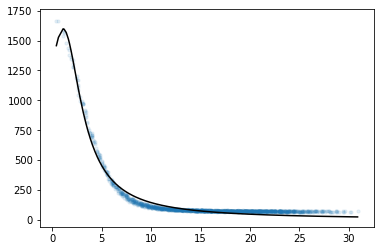

In [15]:
plt.plot(xx, g_fit(xx), c="k")
plt.scatter(dist.ravel(), y, alpha = .1, s=10)


In [16]:
g_fit.fwhm

4.647908395872432

# Get distribution ellipticity

Will use IRAF's description of a method using the [image moments](https://en.wikipedia.org/wiki/Image_moment), described on the documentation of the psfmeasure task. 

In [17]:
mx = np.sum(indices[1]**2 * star) / sum_
my = np.sum(indices[0]**2 * star) / sum_
mxy = np.sum(indices[0] * indices[1] * star) / sum_



m1 = (mx - my)/(mx + my)
m2 = 2*mxy / (mx + my)

ellip = (m1**2 + m2**2) ** 1/2
ellip

0.49043003602241914

> It looks bad. Realized that even the imexamine is not very great at doing so. Will abandon this idea for a moment.

# Making an general function

Get all the ideas into a function for some tests

In [33]:
from photutils.centroids import centroid_1dg

def mfwhm(star_):

    # Get centroid
    star_2 = np.copy(star_)
    sky = star.min()
    print("Sky~", sky)

    # Rough sky subtraction
    star_2 -= sky

    #  Defining half maxima
    #half_maxima = star_.max()/2

    #  Mask to get all values above half maxima
    #hm_mask = star_ >= half_maxima
    #star_[~hm_mask] = 0

    #sum_ = star_.sum()
    indices = np.ogrid[[slice(0, i) for i in star_.shape]]
    #sx = np.sum(indices[1] * star_)
    #sy = np.sum(indices[0] * star_)

    #xc = sx/sum_
    #yc = sy/sum_
    
    tx, ty = centroid_1dg(star_2)
    print(abs(tx-xc), abs(ty-xc))
    
    # Prepare data for Moffat model
    
    # dist = np.sqrt((yc - indices[0])**2 + (xc - indices[1])**2)
    dist = np.sqrt((ty - indices[0])**2 + (tx - indices[1])**2)
    
    # Fit model
    
    x = dist.ravel()
    y = star_2.ravel()

    g_init = Moffat1D(amplitude = star_2.max(), x_0 = 0)
    fitter = LevMarLSQFitter()

    g_fit = fitter(g_init, x, y)
    
    xx = np.linspace(-1, 10, 100)
    plt.plot(xx, g_fit(xx), c="k")
    plt.scatter(dist.ravel(), y, alpha = .5, s=10)
    plt.show()
    plt.imshow(star_2)
    plt.show()
    
    return g_fit.fwhm

Sky~ 61.632535482446016
0.06176358050767661 2.364847157178822


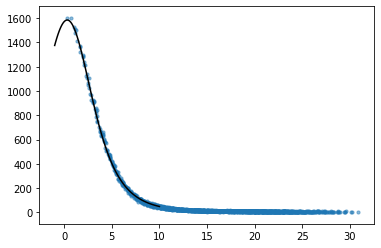

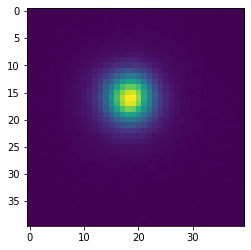

6.177896082799437

In [34]:
star = np.loadtxt("test_star.csv", delimiter=",")
mfwhm(star)

# Testing FWHM against IRAF's imexamine

test-star_0-0.csv
0.04146689725188324 0.6835987729138377


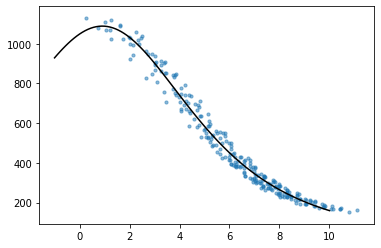

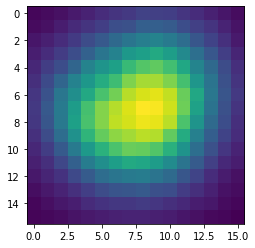

FWHM 8.734118251858037


test-star_0-1.csv
0.034194324715342006 0.4196751120233744


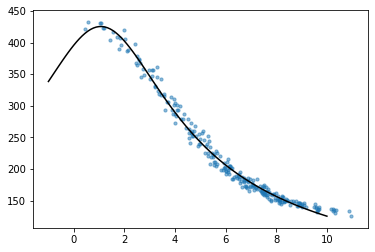

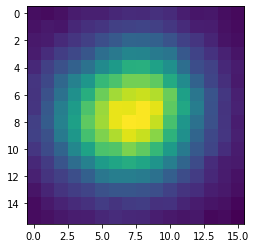

FWHM 9.46761659264842


test-star_0-2.csv
0.4598573589901971 0.42301573127197933


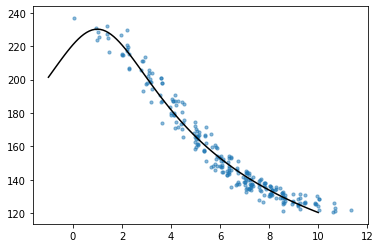

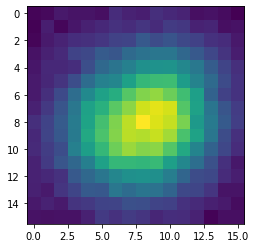

FWHM 19.99549135685867


test-star_0-3.csv
0.2573321242772755 0.12005249919467964


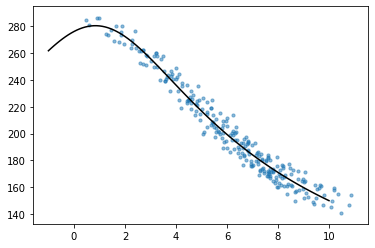

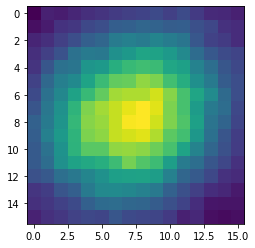

FWHM 20.671166059933128


test-star_1-0.csv
0.0008066780511217786 0.3009733501304783


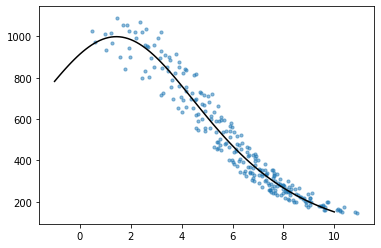

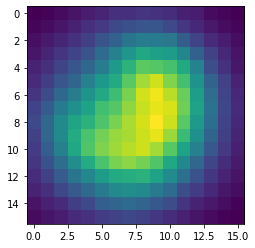

FWHM 8.712953717748634


test-star_1-1.csv
0.35371384403584827 0.21750667317477035


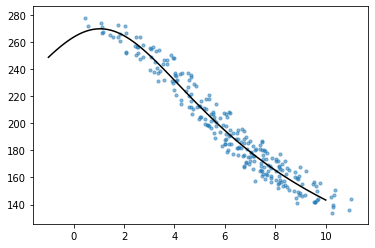

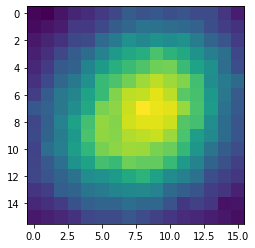

FWHM 19.81312180728017


test-star_1-2.csv
0.10318320301201656 0.3163463675837752


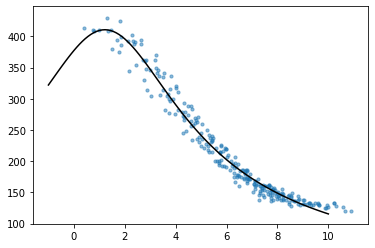

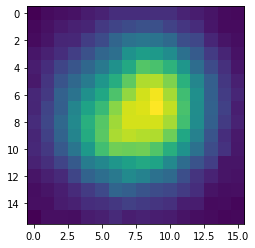

FWHM 9.398495340048198


test-star_1-3.csv
0.0008066780511217786 0.3009733501304783


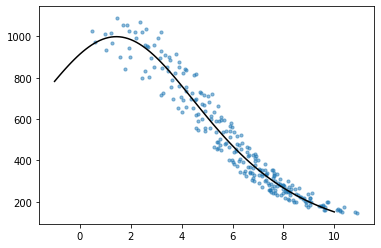

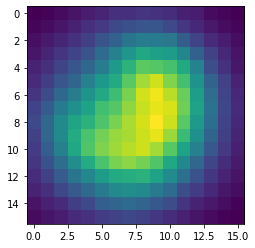

FWHM 8.712953717748634


test-star_2-0.csv
0.06862311766139761 0.15587702074698928


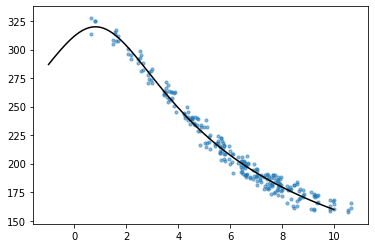

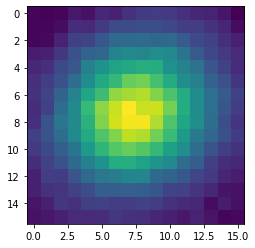

FWHM 18.338400399270583


test-star_2-1.csv
0.04989063338822586 0.1253086418505962


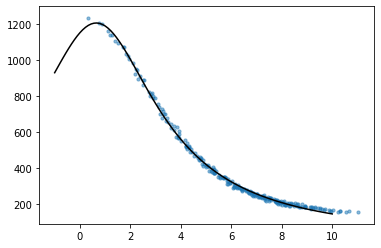

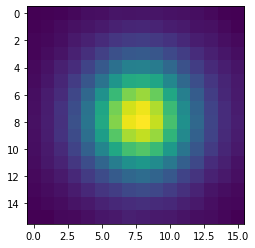

FWHM 6.199639294269822


test-star_2-2.csv
0.011024925769517857 0.25968127549540565


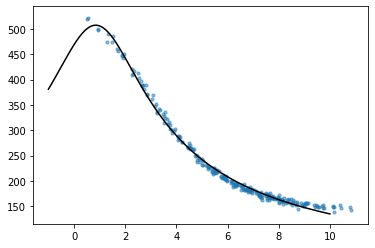

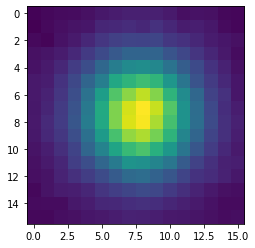

FWHM 7.73872913283602




In [20]:
from glob import glob

l = glob("test-star*")
l.sort()

stars = []
for file in l:
    stars.append(np.loadtxt(file, delimiter=","))

for s, f in zip(stars, l):
    print(f)
    print("FWHM", mfwhm(s))
    print("\n")